# Plot example data for a single patient

In [22]:
# Import libraries
import numpy as np
import pandas as pd
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib
import psycopg2

%matplotlib inline
plt.style.use('ggplot')

font = {'family' : 'DejaVu Sans',
        'size'   : 24}
matplotlib.rc('font', **font)

In [2]:
# Config
sqluser = 'alistairewj'
dbname = 'mimic'
schema_name = 'public,mimiciii'

# append the search path to the beginning of each query
query_schema = 'set search_path to ' + schema_name + ';'

In [3]:
# Connect to MIMIC
con = psycopg2.connect(dbname=dbname, user=sqluser)
# cur.close()
# con.close()

In [4]:
# Select a single ICU stay
icustay_id = 203111 #200282

# Load vitals from chartevents
query = query_schema + """
SELECT ce.icustay_id
  , EXTRACT(epoch FROM ce.charttime - ie.intime)/60.0/60.0 AS icutimehr
  , di.label
  , ce.value
  , ce.valuenum
  , ce.valueuom
FROM chartevents ce
INNER join d_items di
ON ce.itemid = di.itemid
INNER join icustays ie
ON ce.icustay_id = ie.icustay_id
WHERE ce.icustay_id = """ + str(icustay_id) + """
AND error IS DISTINCT FROM 1
AND ce.itemid in
(
220052 -- mean ABP invasive
, 220210,224690 -- RR
, 220277 -- spo2
, 220045 -- HR
)
AND valuenum IS NOT NULL
AND valuenum < 200
ORDER BY ce.charttime, di.label
"""
vitals = pd.read_sql_query(query,con)

# Load tidal volumes and PEEP
query = query_schema + """
SELECT ce.icustay_id
  , EXTRACT(epoch FROM ce.charttime - ie.intime)/60.0/60.0 AS icutimehr
  , EXTRACT(epoch FROM 
          LEAD(ce.charttime) over (PARTITION BY ce.icustay_id, ce.itemid ORDER BY ce.charttime)
          - ie.intime
          )/60.0/60.0 AS icutimehr_next
  , di.label
  , ce.value
  , ce.valuenum
  , ce.valueuom
FROM chartevents ce
INNER join d_items di
ON ce.itemid = di.itemid
INNER join icustays ie
ON ce.icustay_id = ie.icustay_id
WHERE ce.icustay_id = """ + str(icustay_id) + """
AND error IS DISTINCT FROM 1
AND ce.itemid in
(
224684, 224685, 224686 -- tidal volumes
, 220339,224700
)
ORDER BY ce.charttime, di.label
"""
tidal = pd.read_sql_query(query,con)

# Load vasopressor doses
query = query_schema + """
SELECT inp.icustay_id
  , EXTRACT(epoch FROM inp.starttime - ie.intime)/60.0/60.0 AS icustarttimehr
  , EXTRACT(epoch FROM inp.endtime - ie.intime)/60.0/60.0 AS icuendtimehr
  , di.label
  , inp.amount
  , inp.amountuom
  , inp.rate
  , inp.rateuom
FROM inputevents_mv inp
INNER join icustays ie
ON inp.icustay_id = ie.icustay_id
INNER join d_items di
  ON inp.itemid = di.itemid
WHERE inp.icustay_id = """ + str(icustay_id) + """
AND lower(inp.statusdescription) != 'rewritten'
AND inp.itemid in
(
221906,221289,221749,222315,221662,221653,221986
)
ORDER BY inp.starttime
"""
vaso_rx = pd.read_sql_query(query,con)

# Load data from vasopressor durations
query = query_schema + """
select
 vd.icustay_id
 , vd.vasonum
 , EXTRACT(epoch FROM vd.starttime - ie.intime)/60.0/60.0 as icustarttimehr
 , EXTRACT(epoch FROM vd.endtime - ie.intime)/60.0/60.0 as icuendtimehr
from vasopressordurations vd
INNER join icustays ie
ON vd.icustay_id = ie.icustay_id
where vd.icustay_id = """ + str(icustay_id) + """
order by vd.starttime
"""
vaso_dur = pd.read_sql_query(query,con)

# Load data from ventilation durations
query = query_schema + """
select
 vd.icustay_id
 , vd.ventnum
 , EXTRACT(epoch FROM vd.starttime - ie.intime)/60.0/60.0 as icustarttimehr
 , EXTRACT(epoch FROM vd.endtime - ie.intime)/60.0/60.0 as icuendtimehr
from ventdurations vd
INNER join icustays ie
ON vd.icustay_id = ie.icustay_id
where vd.icustay_id = """ + str(icustay_id) + """
order by vd.starttime
"""
vent_dur = pd.read_sql_query(query,con)

# Snip data to specified number of days
#maxhours = 5*24.0
#vitals = vitals.loc[vitals.icutimehr<=maxhours]
#tidal = tidal.loc[tidal.icutimehr<=maxhours]
#vent_dur = vent_dur.loc[vent_dur.icustarttimehr<=maxhours]
#vaso_dur = vaso_dur.loc[vaso_dur.icustarttimehr<=maxhours]
#vaso_rx = vaso_rx.loc[vaso_rx.icustarttimehr<=maxhours]

In [5]:
"""
# sometimes we need to add a fix where we insert NaN values because we know the patient left the ICU temporarily
# usually we know this because of a long gap in the vital sign recordings
# a better approach would be to look for gaps > 2 hours, and insert these None values automatically
vitals_add = pd.DataFrame.from_dict(
    {0: [icustay_id, 42, 'Heart Rate', None, None, 'bpm'],
     1: [icustay_id, 42, 'Respiratory Rate', None, None, 'insp/min'],
     2: [icustay_id, 42, 'O2 saturation pulseoxymetry', None, None, '%'],
     3: [icustay_id, 42, 'Arterial Blood Pressure mean', None, None, 'mmHg'],
     4: [icustay_id, 35, 'Heart Rate', None, None, 'bpm'],
     5: [icustay_id, 35, 'Respiratory Rate', None, None, 'insp/min'],
     6: [icustay_id, 35, 'O2 saturation pulseoxymetry', None, None, '%'],
     7: [icustay_id, 35, 'Arterial Blood Pressure mean', None, None, 'mmHg'],
    }, orient='index')
vitals_add.columns=['icustay_id','icutimehr','label','value','valuenum','valueuom']
vitals = pd.concat([vitals, vitals_add], axis=0, join='outer', ignore_index=True)

# must sort vitals, otherwise matplotlib will still connect data with lines
vitals.sort_values(['icustay_id','icutimehr','label'], axis=0, ascending=True, inplace=True)
"""

"\n# sometimes we need to add a fix where we insert NaN values because we know the patient left the ICU temporarily\n# usually we know this because of a long gap in the vital sign recordings\n# a better approach would be to look for gaps > 2 hours, and insert these None values automatically\nvitals_add = pd.DataFrame.from_dict(\n    {0: [icustay_id, 42, 'Heart Rate', None, None, 'bpm'],\n     1: [icustay_id, 42, 'Respiratory Rate', None, None, 'insp/min'],\n     2: [icustay_id, 42, 'O2 saturation pulseoxymetry', None, None, '%'],\n     3: [icustay_id, 42, 'Arterial Blood Pressure mean', None, None, 'mmHg'],\n     4: [icustay_id, 35, 'Heart Rate', None, None, 'bpm'],\n     5: [icustay_id, 35, 'Respiratory Rate', None, None, 'insp/min'],\n     6: [icustay_id, 35, 'O2 saturation pulseoxymetry', None, None, '%'],\n     7: [icustay_id, 35, 'Arterial Blood Pressure mean', None, None, 'mmHg'],\n    }, orient='index')\nvitals_add.columns=['icustay_id','icutimehr','label','value','valuenum','va

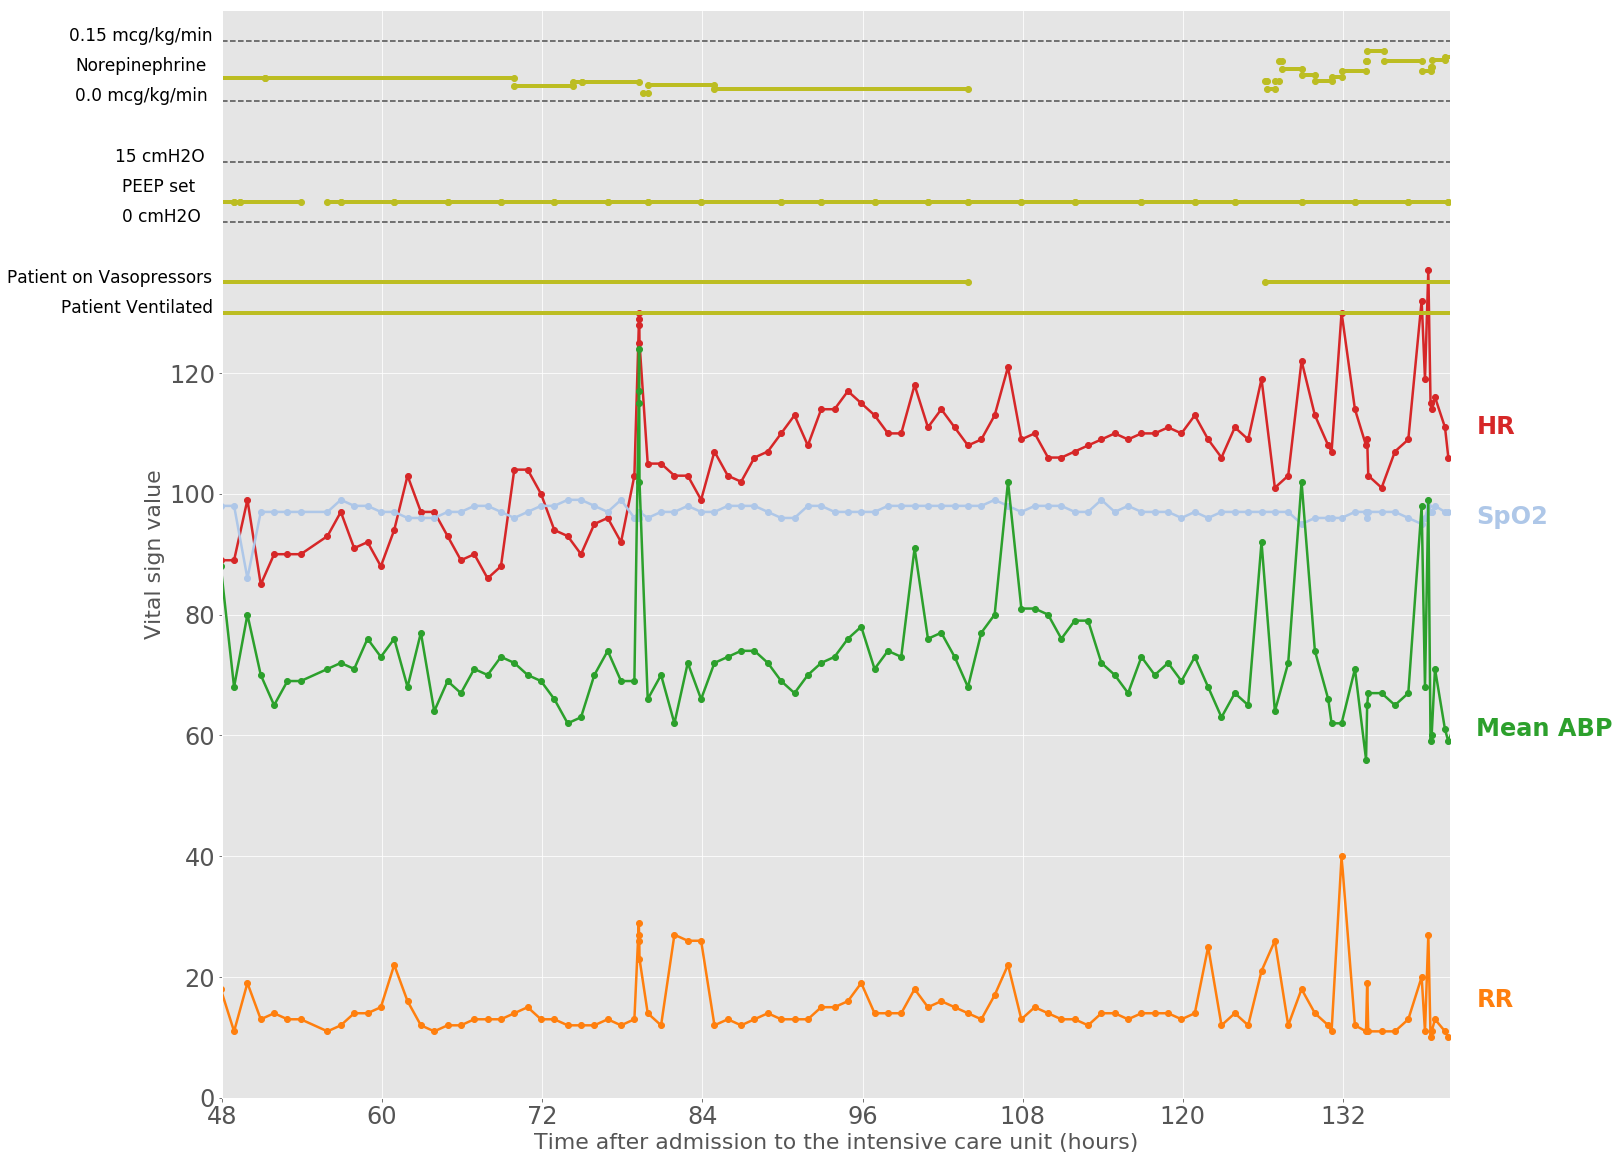

In [29]:
# Plot sample data over first 24 hours from admission to ICU
# Credit: Randal Olson for styling (http://www.randalolson.com/2014/06/28/)

# Prepare the size of the figure
fig = plt.figure(figsize=(22, 20))

# "Tableau 20" colors as RGB.   
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
# Remove the plot frame lines. 
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
ax.axis([48,140,0,180])

lbl_xloc = ax.get_xlim()[0]


vitals_to_plot = OrderedDict([
        ['HR', ['Heart Rate',6]]
        ,['SpO2', ['O2 saturation pulseoxymetry',1]]
        ,['Mean ABP', ['Arterial Blood Pressure mean',4]]
        ,['RR', ['Respiratory Rate',2]]
    ])

# Plot vital signs
for vname in vitals_to_plot:
    v = vitals_to_plot[vname][0] # label name
    c = vitals_to_plot[vname][1] # color
    c = tableau20[c]
    
    plt.plot(vitals.icutimehr[vitals.label==v], 
             vitals.valuenum[vitals.label==v],
             color=c, lw=2.5,
             marker='o', markersize=6, label=vname)

# Plot intravenous meds

# original data min/max
M_MIN = np.floor(vaso_rx.loc[(vaso_rx["label"] =='Norepinephrine'),'rate'].min())
M_MAX = 0.15

# plot min/max
P_MIN = 165
P_MAX = 175

# don't plot text overlapping by using 
for i,row in vaso_rx.loc[(vaso_rx["label"] =='Norepinephrine') & (vaso_rx["rate"] > 0)].iterrows():
    plt.plot([row['icustarttimehr'],row['icuendtimehr']],
             [(row['rate']-M_MIN)/(M_MAX-M_MIN)*(P_MAX-P_MIN)+P_MIN,
             (row['rate']-M_MIN)/(M_MAX-M_MIN)*(P_MAX-P_MIN)+P_MIN],
             color=tableau20[16], lw=4,marker='o', markersize=6)

# add text
plt.text(lbl_xloc-11,(P_MAX+P_MIN)/2.0,'Norepinephrine',fontsize=17)
plt.text(lbl_xloc-11,P_MIN,str(M_MIN) + ' ' + str(row['rateuom']),fontsize=17)
plt.text(lbl_xloc-11.5,P_MAX,str(M_MAX) + ' ' + str(row['rateuom']),fontsize=17)

plt.plot(ax.get_xlim(), [P_MIN, P_MIN], 'k--', lw=2, alpha=0.5)
plt.plot(ax.get_xlim(), [P_MAX, P_MAX], 'k--', lw=2, alpha=0.5)

# below if you want to plot phenylephrine
"""
lbl = 'Phenylephrine'
M_MIN = 0.0
M_MAX = 2.0

# plot min/max
P_MIN = 145
P_MAX = 155

for i,row in vaso_rx.loc[(vaso_rx["label"] == lbl) & (vaso_rx["rate"] > 0)].iterrows():
    plt.plot([row['icustarttimehr'],row['icuendtimehr']],
             [(row['rate']-M_MIN)/(M_MAX-M_MIN)*(P_MAX-P_MIN)+P_MIN,
             (row['rate']-M_MIN)/(M_MAX-M_MIN)*(P_MAX-P_MIN)+P_MIN],
             color=tableau20[16], lw=4,marker='o', markersize=6)
"""

lbl = 'PEEP set'
M_MIN = 0
M_MAX = 15

# plot min/max
P_MIN = 145
P_MAX = 155

for i,row in tidal.loc[(tidal["label"] == lbl) & (tidal["valuenum"] > 0)].iterrows():
    plt.plot([row['icutimehr'],row['icutimehr_next']],
             [(row['valuenum']-M_MIN)/(M_MAX-M_MIN)*(P_MAX-P_MIN)+P_MIN,
            (row['valuenum']-M_MIN)/(M_MAX-M_MIN)*(P_MAX-P_MIN)+P_MIN],
             color=tableau20[16], lw=4,marker='o', markersize=6)


# add text
plt.text(lbl_xloc-7.5,(P_MAX+P_MIN)/2.0,lbl,fontsize=17)
plt.text(lbl_xloc-7.5,P_MIN,str(M_MIN) + ' ' + str(row['valueuom']),fontsize=17)
plt.text(lbl_xloc-8.0,P_MAX,str(M_MAX) + ' ' + str(row['valueuom']),fontsize=17)

plt.plot(ax.get_xlim(), [P_MIN, P_MIN], 'k--', lw=2, alpha=0.5)
plt.plot(ax.get_xlim(), [P_MAX, P_MAX], 'k--', lw=2, alpha=0.5)

yloc = 135
plt.text(lbl_xloc-16.1,yloc,'Patient on Vasopressors',fontsize=17)
for i,row in vaso_dur.iterrows():
    plt.plot([row['icustarttimehr'],row['icuendtimehr']],[yloc]*2,
             color=tableau20[16], lw=4,marker='o', markersize=6)
    #plt.text(row['icustarttimehr'],150,
    #         str(round(row['rate'],1)) + ' ' + str(row['rateuom']),
    #         fontsize=15)

# Plot ventilator durations
yloc = 130
plt.text(lbl_xloc-12.1,yloc,'Patient Ventilated',fontsize=17)
for i,row in vent_dur.iterrows():
    plt.plot([row['icustarttimehr'],row['icuendtimehr']],[yloc]*2,
             color=tableau20[16], lw=4,marker='o', markersize=6)
    #plt.text(row['icustarttimehr'],145,
    #         str(round(row['rate'],1)) + ' ' + str(row['rateuom']),
    #         fontsize=15)
       
# Plot code status
#plt.text(-10,220,'Code status',fontsize=17) 
#for i, txt in enumerate(charts.value[charts.label=='Code Status'].values):
#        plt.annotate(txt, (charts.icutimehr[charts.label=='Code Status'].
#                           values[i],220),fontsize=17)
        
plt.xlabel('Time after admission to the intensive care unit (hours)', fontsize=22)
plt.ylabel('Vital sign value', fontsize=22)
plt.yticks(np.arange(0, 140, 20))


plt.xticks(np.arange(ax.get_xlim()[0], ax.get_xlim()[1], 12))

#plt.legend(loc=[25,56],fontsize=24)

xloc_right = ax.get_xlim()[1] + 2
textLocs = {'HR': [xloc_right, 110],
            'SpO2': [xloc_right, 95],
            'Mean ABP': [xloc_right, 60],
            'RR': [xloc_right, 15] }

# add text on the right of the lines
for v in textLocs:
    c = vitals_to_plot[v][1] # color
    c = tableau20[c]
    
    plt.text(textLocs[v][0], textLocs[v][1], v, color=c, fontweight='bold')

plt.show()
# Save the figure
fig.savefig('examplepatient.pdf', bbox_inches='tight')
fig.savefig('example-patient.png', bbox_inches='tight')

In [7]:
con.close()